In [23]:
import tensorflow as tf
from tensorflow import keras

from nn.alice import dataset, model
from physics.hstar import gghzz, c6
from physics.simulation import msq
from physics.hzz import zpair, angles

import os
import json
import numpy as np
import matplotlib.pyplot as plt

import hist

from sklearn.preprocessing import MinMaxScaler

In [24]:
SEED=373485

BASE_SIZE=100000

OUTPUT_DIR='jobs/alice/run-one-sbi-check'
CONF_FILE='alice-config.json'
SCALER_CONF='scaler.json'
SAMPLE_DIR='..'

In [25]:
with open(os.path.join(OUTPUT_DIR, CONF_FILE), 'r') as conf_file:
    config = json.load(conf_file)

In [26]:
sample_train = gghzz.Process(msq.Component.SBI, (1.5, os.path.join(SAMPLE_DIR, 'ggZZ2e2m_sbi.csv'), 1.2*BASE_SIZE))
sample_val = gghzz.Process(msq.Component.SBI, (1.5, os.path.join(SAMPLE_DIR, 'ggZZ2e2m_sbi.csv'), config['num_events'] + 1.2*BASE_SIZE))
sample_val.events = sample_val.events[config['num_events']:]

In [27]:
z_chooser = zpair.ZPairChooser(bounds1=(70,115), bounds2=(70,115), algorithm='leastsquare')
kin_vars_train = angles.calculate_2(*sample_train.events.filter(z_chooser))
kin_vars_val = angles.calculate_2(*sample_val.events.filter(z_chooser))

sample_train.events = sample_train.events[:BASE_SIZE]
kin_vars_train = kin_vars_train[:BASE_SIZE]
sample_val.events = sample_val.events[:BASE_SIZE]
kin_vars_val = kin_vars_val[:BASE_SIZE]

In [28]:
c6_values = [-20,-10,0,10,20]

c6_mod_train = c6.Modifier(baseline = msq.Component.SBI, sample=sample_train, c6_values = [-5,-1,0,1,5])
c6_weights_train, c6_prob_train = c6_mod_train.modify(c6=c6_values)

c6_mod_val = c6.Modifier(baseline = msq.Component.SBI, sample=sample_train, c6_values = [-5,-1,0,1,5])
c6_weights_val, c6_prob_val = c6_mod_val.modify(c6=c6_values)

In [29]:
train_set = dataset.build_dataset(x_arr=kin_vars_train, 
                                  param_values=c6_values, 
                                  signal_probabilities=c6_weights_train, 
                                  background_probabilities=sample_train.events.weights)
val_set = dataset.build_dataset(x_arr=kin_vars_val, 
                                param_values=c6_values, 
                                signal_probabilities=c6_weights_val, 
                                background_probabilities=sample_val.events.weights)

In [30]:
with open(os.path.join(OUTPUT_DIR, SCALER_CONF), 'r') as conf_file:
    scaler_conf = json.load(conf_file)

In [31]:
scaler = MinMaxScaler()
scaler.min_ = scaler_conf['scaler.min_']
scaler.scale_ = scaler_conf['scaler.scale_']

train_set = tf.concat([scaler.transform(train_set[:,:10]), train_set[:,10:]], axis=1)
val_set = tf.concat([scaler.transform(val_set[:,:10]), val_set[:,10:]], axis=1)

In [32]:
print(train_set[0])

tf.Tensor(
[1.3554692e-01 1.0560543e-01 8.8412839e-01 9.0740329e-01 6.4314938e-01
 4.3273693e-01 6.9665396e-01 3.3030722e-02 4.8322934e-01 0.0000000e+00
 5.0895286e-01 1.8336519e-05], shape=(12,), dtype=float32)


In [33]:
rolr_model = model.load(os.path.join(OUTPUT_DIR, 'checkpoint.model.tf'))

In [34]:
predictions_train = rolr_model.predict(train_set[:,:10])
predictions_val = rolr_model.predict(val_set[:,:10])

15625/15625 [==============================] - 26s 2ms/step


In [35]:
pred_train_per_c6 = {c6_values[i]: predictions_train[i*BASE_SIZE:(i+1)*BASE_SIZE] for i in range(len(c6_values))}
data_train_per_c6 = {c6_values[i]: train_set[i*BASE_SIZE:(i+1)*BASE_SIZE] for i in range(len(c6_values))}

pred_val_per_c6 = {c6_values[i]: predictions_val[i*BASE_SIZE:(i+1)*BASE_SIZE] for i in range(len(c6_values))}
data_val_per_c6 = {c6_values[i]: val_set[i*BASE_SIZE:(i+1)*BASE_SIZE] for i in range(len(c6_values))}

In [36]:
def generate_histograms(c6_values, data_train_per_c6, pred_train_per_c6, data_val_per_c6, pred_val_per_c6, num_bins):
    histograms = []
    for c6 in c6_values:
        hist_train = hist.Hist(hist.axis.Regular(num_bins, 0, 1, name='x', label='NN output []'))
        hist_train.fill(tf.squeeze(pred_train_per_c6[c6], axis=1), weight=data_train_per_c6[c6][:,-1])

        hist_val = hist.Hist(hist.axis.Regular(num_bins, 0, 1, name='x', label='NN output []'))
        hist_val.fill(tf.squeeze(pred_val_per_c6[c6], axis=1), weight=data_val_per_c6[c6][:,-1])

        hist_true = hist.Hist(hist.axis.Regular(num_bins, 0, 1, name='x', label='NN output []'))
        hist_true.fill(data_train_per_c6[c6][:,-2], weight=data_train_per_c6[c6][:,-1])

        histograms.append((hist_train.to_numpy(), hist_val.to_numpy(), hist_true.to_numpy()))
    
    return histograms

In [37]:
def plot_histograms(c6_values, histograms, colors, xlim=(0.2,0.8)):
    fig = plt.figure(figsize=(7,6))

    for i in range(len(c6_values)):
        plt.step(histograms[i][2][1][1:], histograms[i][2][0], color=colors[i], linestyle='--', label=f'truth (c6={c6_values[i]})', alpha=0.6)
        plt.step(histograms[i][0][1][1:], histograms[i][0][0], color=colors[i], label=f'training data (c6={c6_values[i]})', alpha=0.6)
        plt.scatter(histograms[i][1][1][1:], histograms[i][1][0], s=20, color=colors[i], label=f'validation data (c6={c6_values[i]})', alpha=0.6)

    plt.xlabel('NN output []')
    plt.ylabel('Percentage of predictions []')
    plt.legend()
    plt.xlim(xlim[0],xlim[1])
    plt.yscale('log')

    plt.show()

(100000,)
(100000, 1)


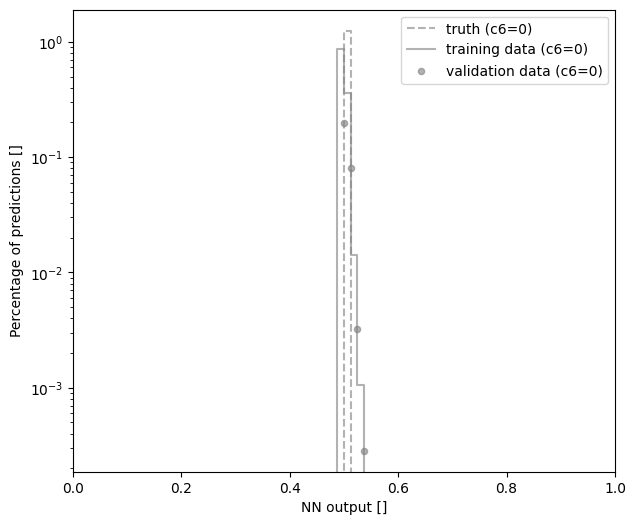

In [ ]:
BINS = 80

c6_vals = [10]
colors = ['limegreen']

print(data_train_per_c6[-10][:,-2].shape)
print(pred_train_per_c6[-10].shape)

histograms = generate_histograms(c6_vals, data_train_per_c6, pred_train_per_c6, data_val_per_c6, pred_val_per_c6, BINS)

plot_histograms(c6_vals, histograms, colors, xlim=(0,1.0))

In [39]:
hist_prm = ''

with open(os.path.join(OUTPUT_DIR, 'history.txt'), 'r') as hist_file:
    hist_prm = hist_file.readlines()

hist_prm = [ np.array(el.replace('[','').replace(']','').replace(' ','').split(','), dtype=float) for el in hist_prm[0].split('][')]

t_loss_prm = np.array(hist_prm[0])
v_loss_prm = np.array(hist_prm[1])

epochs = range(1,t_loss_prm.shape[0]+1)

fig = plt.figure(figsize=(8,6))

#ax1.set_xticklabels([])

plt.plot(epochs, t_loss_prm, 'b', label='Training loss')
plt.xlabel('epochs []')
plt.ylabel(f'loss []')
#ax2.legend()

plt.plot(epochs, v_loss_prm, 'r', label='Validation loss')
#ax1.set_ylabel('loss []')
plt.legend()

fig.tight_layout()

plt.show()

FileNotFoundError: [Errno 2] No such file or directory: 'jobs/alice/run-one-sbi-check/history.txt'

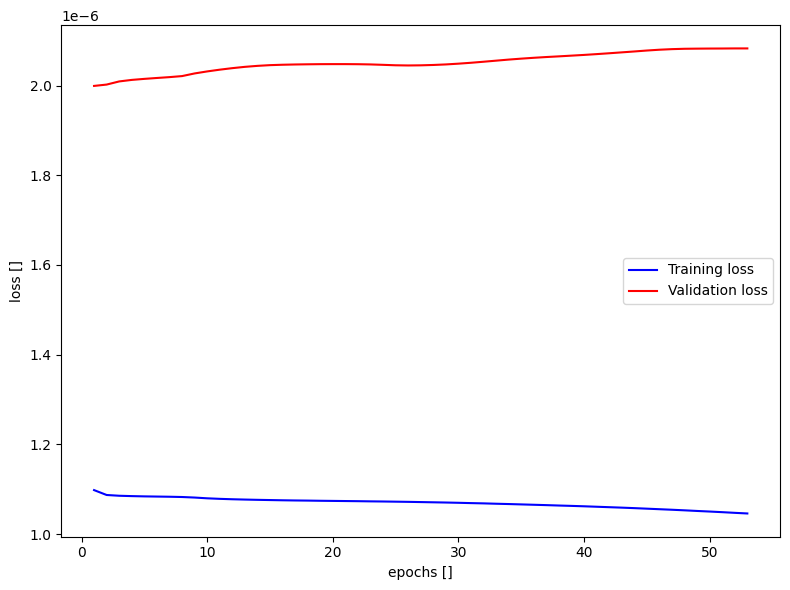

In [ ]:
JOB_ID = 14266437

JOB_OUT_FILE = os.path.join(OUTPUT_DIR, 'logs', 'job.out.' + str(JOB_ID))

import re

with open(JOB_OUT_FILE, 'r') as log_file:
    logs = ''.join(log_file.readlines())

t_loss = np.array(re.findall("\ loss:\ ([0-9]\.[0-9]+e?-?[0-9]*)\ -", logs)).astype(np.float32)
v_loss = np.array(re.findall("\ val_loss:\ ([0-9]\.[0-9]+e?-?[0-9]*)\ -", logs)).astype(np.float32)

epochs = range(1,t_loss.shape[0]+1)

fig = plt.figure(figsize=(8,6))

#ax1.set_xticklabels([])

plt.plot(epochs, t_loss, 'b', label='Training loss')
plt.xlabel('epochs []')
plt.ylabel(f'loss []')
#ax2.legend()

plt.plot(epochs, v_loss, 'r', label='Validation loss')
#ax1.set_ylabel('loss []')
plt.legend()

fig.tight_layout()

plt.show()